In [2]:
import os
import pickle
import math
import random
import csv
from PIL import Image

import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

print('All modules imported.')

All modules imported.


# 1 Reload the preprocessed data

In [3]:
# 1 Reload the preprocessed data

pickle_file = './pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory
    
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames))
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43
Data loaded.


# 2 LeNet Architecture

In [4]:
def LeNet(x, KEEP_PROB):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Input = 32x32x3. Output = 28x28x6.
    # Convolutional. 
    conv1_w = tf.Variable(tf.truncated_normal((5, 5, 3, 6), mu, sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
       
    # Layer 2: Input = 14x14x6. Output = 10x10x16.
    # Convolutional. 
    conv2_w = tf.Variable(tf.truncated_normal((5, 5, 6, 16), mu, sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool1, conv2_w, [1, 1, 1, 1], 'VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
      
    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(pool2)   
    
    # Layer 3: Input = 400. Output = 120.
    # Fully Connected. 
    full1_w = tf.Variable(tf.truncated_normal((400, 120), mu, sigma))
    full1_b = tf.Variable(tf.zeros(120))
    full1 = tf.matmul(flat, full1_w) + full1_b
    # Activation.
    full1 = tf.nn.relu(full1) 
    # Dropout
    full1 = tf.nn.dropout(full1, KEEP_PROB)
    
    # Layer 4: Input = 120. Output = 84.
    # Fully Connected. 
    full2_w = tf.Variable(tf.truncated_normal((120, 84), mu, sigma))
    full2_b = tf.Variable(tf.zeros(84))
    full2 = tf.matmul(full1, full2_w) + full2_b
    # Activation.
    full2 = tf.nn.relu(full2)
    # Dropout
    full2 = tf.nn.dropout(full2, KEEP_PROB)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    full3_w = tf.Variable(tf.truncated_normal((84, 43), mu, sigma))
    full3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(full2, full3_w) + full3_b
    
    return logits

# 3 Training

## 3.1 Strategy

In [5]:
# Placeholder
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder_with_default(1.0, shape=())

# Hyperparameters
LEARNING_RATE = 1e-2
EPOCHS = 50
BATCH_SIZE = 128

# Train method
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## 3.2 Evaluation

In [6]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples, loss

## 3.3 Train the Model
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting. The optimizer used is mini-batch gradient descent, each select a sub batch of all the training data.

Training...
EPOCH 1 : Validation Accuracy = 0.062
EPOCH 2 : Validation Accuracy = 0.109
EPOCH 3 : Validation Accuracy = 0.157
EPOCH 4 : Validation Accuracy = 0.285
EPOCH 5 : Validation Accuracy = 0.388
EPOCH 6 : Validation Accuracy = 0.429
EPOCH 7 : Validation Accuracy = 0.464
EPOCH 8 : Validation Accuracy = 0.510
EPOCH 9 : Validation Accuracy = 0.557
EPOCH 10 : Validation Accuracy = 0.575
EPOCH 11 : Validation Accuracy = 0.607
EPOCH 12 : Validation Accuracy = 0.631
EPOCH 13 : Validation Accuracy = 0.654
EPOCH 14 : Validation Accuracy = 0.704
EPOCH 15 : Validation Accuracy = 0.706
EPOCH 16 : Validation Accuracy = 0.722
EPOCH 17 : Validation Accuracy = 0.759
EPOCH 18 : Validation Accuracy = 0.775
EPOCH 19 : Validation Accuracy = 0.781
EPOCH 20 : Validation Accuracy = 0.807
EPOCH 21 : Validation Accuracy = 0.814
EPOCH 22 : Validation Accuracy = 0.823
EPOCH 23 : Validation Accuracy = 0.831
EPOCH 24 : Validation Accuracy = 0.834
EPOCH 25 : Validation Accuracy = 0.847
EPOCH 26 : Validation 

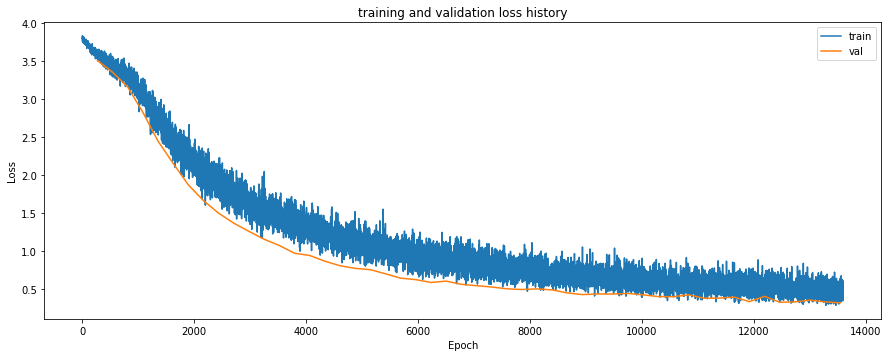

Wall time: 13min 17s


In [7]:
%%time
# 2min 7s
train_losses = []
valid_losses = []
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        print("EPOCH {} :".format(i+1), end=' ')
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, train_loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            train_losses.append(train_loss)
        validation_accuracy, valid_loss = evaluate(X_valid, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        valid_losses.append(valid_loss)
                
    saver.save(sess, './model1/lenet.ckpt')
    print("Model saved")
    
plt.subplot(2, 1, 2)
plt.plot(train_losses, label='train')
plt.plot([(i+1) * int(num_examples / BATCH_SIZE) for i in range(EPOCHS)], valid_losses, label='val')
plt.title('training and validation loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15, 12)
plt.legend()
plt.show()

# 4 Testing

## 4.1 Test the model on testing dataset

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model1/lenet.ckpt


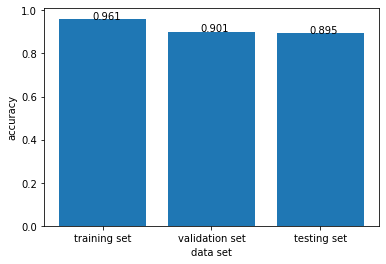

In [10]:
with tf.Session() as sess:
    saver.restore(sess, './model1/lenet.ckpt')
    train_accuracy,_ = evaluate(X_train, y_train)
    valid_accuracy,_ = evaluate(X_valid, y_valid)
    test_accuracy,_ = evaluate(X_test, y_test)
    
accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('data set')
plt.ylabel('accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()

## 4.2 Test the Model on New Images
 
To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type. You may find signnames.csv useful as it contains mappings from the class id (integer) to the actual sign name.

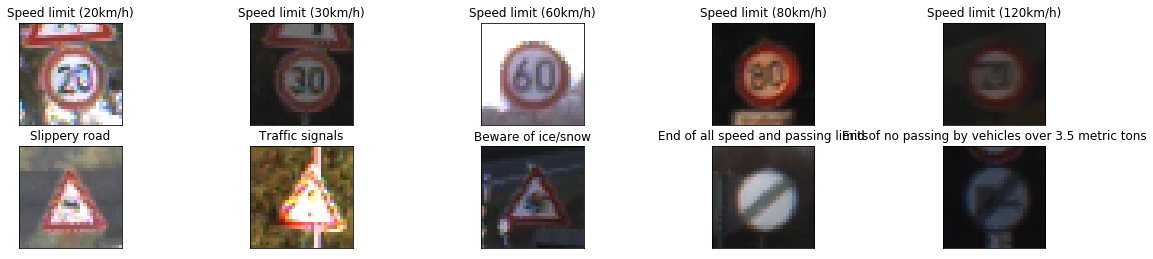

In [11]:
gt_images = []
gt_labels = []

with open('./test_images/labels.csv') as f:
    gt_labels = [row[7] for row in csv.reader(f)]
# print(gt_labels)

for i in range(1, 11):
    img = Image.open('./test_images/' + str(i) +'.ppm')
    img.save('./test_images/' + str(i) +'.jpg')
    gt_images.append(plt.imread('./test_images/' + str(i) +'.ppm'))
# print(gt_images)

plt.figure(figsize=(20, 20))
for i in range(len(gt_images)):
    plt.subplot(9, 5, i + 1), plt.imshow(gt_images[i]), plt.title(signnames[int(gt_labels[i])])
    plt.xticks([]), plt.yticks([])
    
gt_images = np.array(gt_images)
gt_labels = np.array(gt_labels)
    
# Normalization
gt_images = gt_images.astype(np.float32) / 128. - 1.

In [12]:
#Predict the Sign Type for Each Image

with tf.Session() as sess:
    saver.restore(sess, './model1/lenet.ckpt')
    test_accuracy = evaluate(gt_images, gt_labels)
    #print("Test Accuracy = {:.3f}".format(test_accuracy))   
    logits_value = sess.run(logits, feed_dict={x: gt_images})
    probabilities = sess.run(tf.nn.softmax(logits_value))
    
predict = probabilities.argmax(axis=1)
print("Predict the Sign Type for Each Image")
print(predict)

INFO:tensorflow:Restoring parameters from ./model1/lenet.ckpt
Predict the Sign Type for Each Image
[ 1  1  3  5  8 23 26 23 32 42]


## Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the certainty of the model's predictions (limit the output to the top 5 probabilities for each image). tf.nn.top_k could prove helpful here.

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

tf.nn.top_k will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

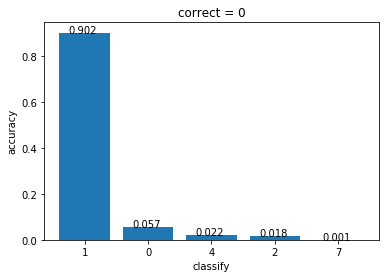

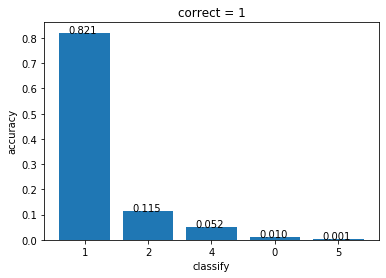

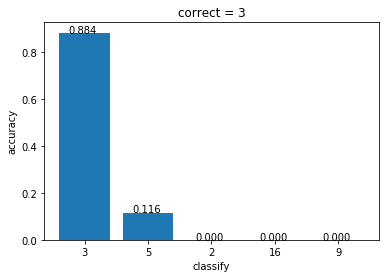

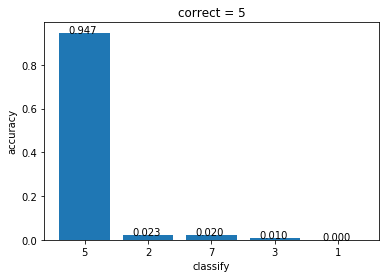

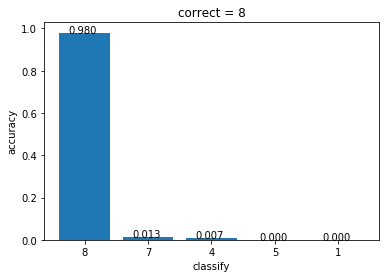

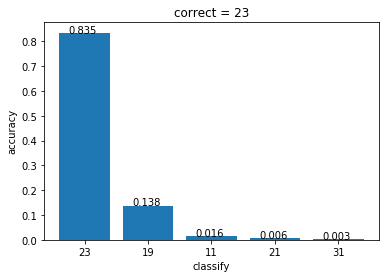

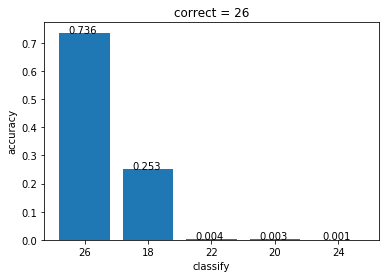

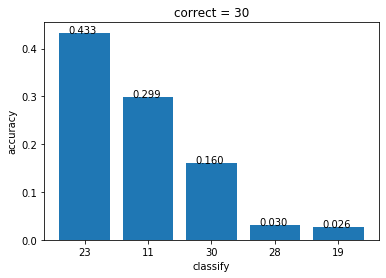

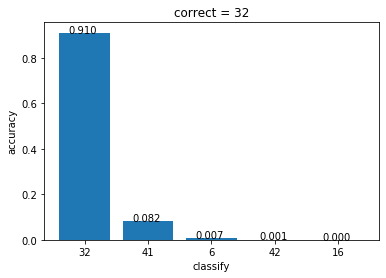

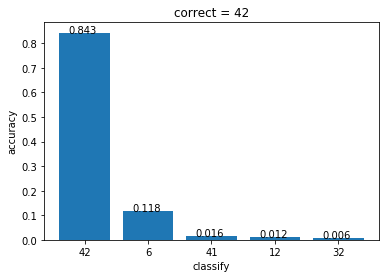

In [13]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(probabilities), k=5))

def plt_bar(values, indicex, answer):
    plt.bar(range(5), values)
    plt.xlabel('classify')
    plt.ylabel('accuracy')
    plt.xticks(range(5), indicex)
    plt.title("correct = "+answer)
    for x_,y_ in zip(range(5), values):
        plt.text(x_ - 0.25, y_, '%.3f'%y_)
    plt.show()

for i in range(10):
    plt_bar(top5.values[i], top5.indices[i], gt_labels[i])

## Accuracy for predicting unknown images from Web

In [14]:
gt_labels

array(['0', '1', '3', '5', '8', '23', '26', '30', '32', '42'], dtype='<U2')

In [15]:
predict

array([ 1,  1,  3,  5,  8, 23, 26, 23, 32, 42], dtype=int64)

In [16]:
cnt=0
for i in range(predict.size):
    if int(gt_labels[i]) == predict[i]:
        cnt = cnt+1

pred_acc = (cnt/predict.size)*100
print("Accuracy for Predicting unknown images from web:",pred_acc,"%")

Accuracy for Predicting unknown images from web: 80.0 %
